<a href="https://colab.research.google.com/github/sushmita56/Image-Caption-Generation/blob/master/Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pickle
import numpy as np

from tqdm.notebook import tqdm    # tqdm create simple & hassle-free progress bars
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"poudelsushmita","key":"5f195b261254924e6df6289c4f0f1193"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:31<00:00, 34.4MB/s]
100% 1.04G/1.04G [00:31<00:00, 35.6MB/s]


In [6]:
# ! rm -rf Images

In [7]:
! unzip /content/flickr8k.zip -d /content/flickr8k 


Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: /content/flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: /content/flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: /content/flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: /content/flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: /content/flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: /content/flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/fli

In [8]:
base_model = VGG16()
base_model.summary()

553467096/553467096 [==============================] - 17s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [9]:
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
! pwd

/content


In [11]:
BASE_DIR = '/content/flickr8k'
WORKING_DIR = '/content'

In [12]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
  img_path = directory + '/' + img_name
  image = load_img(img_path, target_size=(224,224))
  # convert image pixels to numpy array
  image =img_to_array(image)
  # reshape data for model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  # preprocess image for vgg
  image = preprocess_input(image)
  # extract features
  feature = model.predict(image, verbose=0)
  # get image ID
  image_id = img_name.split('.')[0]
  # store feature
  features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [13]:
# store preprocessed features 
pickle.dump(features, open(os.path.join(WORKING_DIR, 'processed_features.pkl'), 'wb'))

In [14]:
# load stored features from pickle
with open(os.path.join(WORKING_DIR, 'processed_features.pkl'), 'rb') as f:
  features = pickle.load(f)

# Load the caption data

In [15]:
BASE_DIR

'/content/flickr8k'

In [16]:
# load the caption data from captions.txt file that is inside flickr8k
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
  next(f)
  image_captions = f.read()

In [17]:
# for each image id we've their corresponding caption
# for this let's create a mapping of an image to its corresponding caption
caption_mapping = {}
# process lines
for line in tqdm(image_captions.split('\n')):
    # again split each line by comma as the file name and caption is separated by comma
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove .jpg extendion from image id
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # if image id is not in caption mapping dictionary, we add the image_id onto the dictionary
    # else if image_id already exists on the dictionary then we will store caption of the corresponding image_id
    if image_id not in caption_mapping:
        caption_mapping[image_id] = []
    # store the caption
    caption_mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [18]:
len(caption_mapping)

8091

In [19]:
def preprocess_caption(caption_mapping):
  for id, captions in caption_mapping.items():
    for i in range(len(captions)):
      # process 1 caption at a time
      caption = captions[i]
      caption = caption.lower()
      # delete everything like digits, special characters except alphabets
      caption = caption.replace('[^A-Za-z]', '')
      caption = caption.replace('\s+', ' ')          
      # add start and end tag to caption
      # default separator in split() function is any whitespace
      caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq' 
      captions[i] = caption

In [20]:
# before text processing
caption_mapping['1002674143_1b742ab4b8']

['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails painting outside in the grass .']

In [21]:
preprocess_caption(caption_mapping)

In [22]:
# after text processing
caption_mapping['1002674143_1b742ab4b8']

['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq',
 'startseq there is girl with pigtails sitting in front of rainbow painting endseq',
 'startseq young girl with pigtails painting outside in the grass endseq']

In [23]:
all_captions = []
for key in caption_mapping:
    for value in caption_mapping[key]:
        all_captions.append(value)

In [24]:
all_captions[5:10]

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [25]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [26]:
# get maximum length of the caption
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Train Test Split

In [27]:
image_ids = list(caption_mapping.keys())
split = int(len(image_ids) * 0.9)
train = image_ids[:split]   # take 90% of data as training data
test = image_ids[split:]    # remaining 10% will be used as a test data

In [28]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

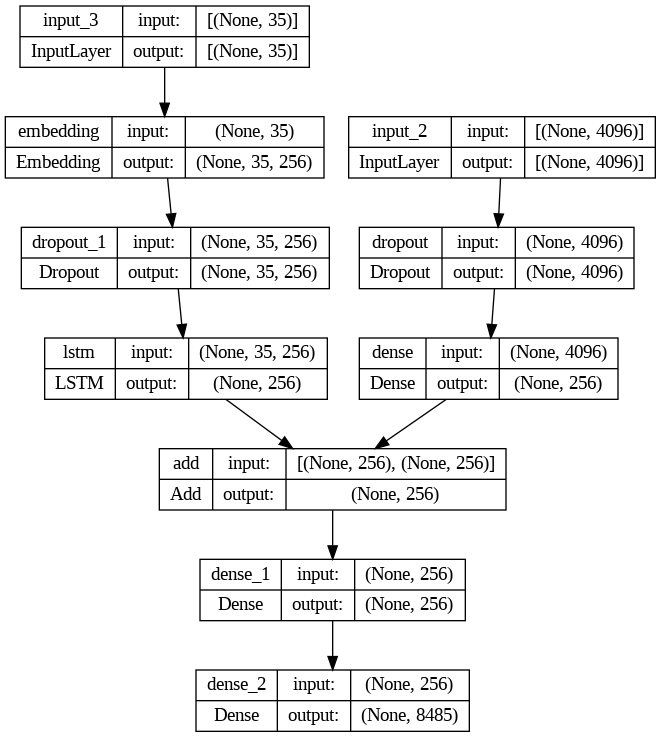

In [29]:
inputs1 = Input(shape=(4096,))  # the output of vgg model i.e. 4096 will be used as an input
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [30]:
# train the model
epochs = 15
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, caption_mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 37s 325ms/step - loss: 2.5138


In [31]:
# save the model
model.save(WORKING_DIR + '/caption_model2.h5')

# Generate captions for image

In [35]:
# we've to convert image id to word at first
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [36]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
  in_text = 'startseq'
  # iterate over max_length of the sequnece
  for i in range(max_length):
    # encode sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad sequence
    sequence = pad_sequences([sequence], max_length)
    # predict next word
    y_hat = model.predict([image, sequence], verbose=0)
    # get index with high probability
    y_hat = np.argmax(y_hat)
    # convert index to word or caption
    word = idx_to_word(y_hat, tokenizer)
    # stop if word not found:
    if word is None:
      break
    # append word as input for generating next word
    in_text += " " + word
    # stop if we reach end tag
    if word == 'endseq':
      break
  return in_text

## Model Evaluation

In [37]:
from nltk.translate.bleu_score import corpus_bleu

In [38]:
actual, predicted = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = caption_mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)
  # split actual caption into multiple words
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  actual.append(actual_captions)
  predicted.append(y_pred)

  0%|          | 0/810 [00:00<?, ?it/s]

In [39]:
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.567247
BLEU-2: 0.345369


# Visualize the result

In [49]:
# image_name = "1001773457_577c3a7d70.jpg"
# os.path.join(BASE_DIR, "Images", image_name)

In [60]:
!pip install simple-colors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
from simple_colors import *

print(green('Hello', ['bold']))

Hello


In [64]:
def show_caption(img_name):
    image_id = img_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", img_name)
    image = Image.open(img_path)
    captions = caption_mapping[image_id]
    print(green('Actual Caption', ['bold']))
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(green('\nModel Predicted Caption', ['bold']))
    print(y_pred)
    plt.imshow(image)

Actual Caption
startseq two girls are walking arm in arm past an amusement arcade endseq
startseq two girls are walking away from the camera under walkway endseq
startseq two girls in shorts walk towards casino signs endseq
startseq two teenage girls walking down mall breezeway endseq
startseq two women walk on the sidewalk endseq

Model Predicted Caption
startseq man in green shirt is walking down the street endseq


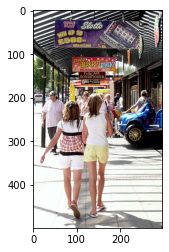

In [73]:
show_caption("979201222_75b6456d34.jpg")

Actual Caption
startseq boy licks an older male 's face that 's covered in blue and yellow creamy substance endseq
startseq child in yellow shirt is licking brightly colored food off of mans cheek endseq
startseq young boy is licking blue and yellow frosting off young man 's face endseq
startseq young boy is licking colored frosting off young man 's face endseq
startseq someone licks the face of man with blue and yellow paint on his face endseq

Model Predicted Caption
startseq baby with glasses and glasses is holding baby in the cheeks endseq


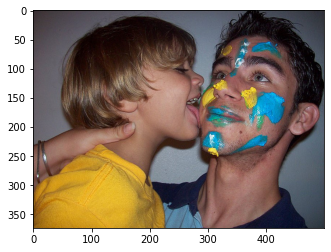

In [72]:
show_caption("957230475_48f4285ffe.jpg")

Actual Caption
startseq large tent with green cover at campground endseq
startseq tent and campsite in sunlit forest endseq
startseq picture of campsite with big green tent endseq
startseq rays of sunlight shine down on green tent in the woods endseq
startseq the sun is blazing through the trees onto green tent in the woods endseq

Model Predicted Caption
startseq the person is sitting on the forest with the water endseq


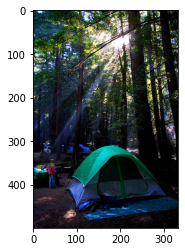

In [74]:
show_caption('958326692_6210150354.jpg')

Actual Caption
startseq boy and dog on dock are watching another dog swim away endseq
startseq boy and dog stand on dock watching another dog endseq
startseq boy and large dog stand on dock watching another dog swim in the water endseq
startseq boy and his dog are watching an object in the water endseq
startseq boy in white shirt and black dog looking at another dog in the water endseq

Model Predicted Caption
startseq dog is walking through the water endseq


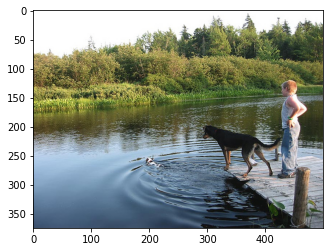

In [75]:
show_caption('944788251_a0bcd4b960.jpg')

Actual Caption
startseq hiker waves to the camera as he standing in front of snowcapped mountains endseq
startseq man stands on the snow near the mountains endseq
startseq person poses in the snow endseq
startseq "a person stands in the snow at the top of mountian arms raised ." endseq
startseq skier in the mountains endseq

Model Predicted Caption
startseq man is standing on mountain overlooking snow endseq


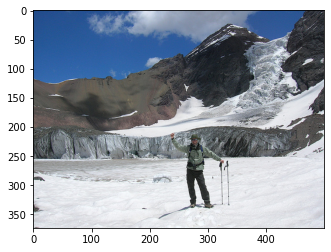

In [69]:
show_caption('2097398349_ff178b3f1b.jpg')

Actual Caption
startseq group is sitting around snowy crevasse endseq
startseq group of people sit atop snowy mountain endseq
startseq group of people sit in the snow overlooking mountain scene endseq
startseq five children getting ready to sled endseq
startseq five people are sitting together in the snow endseq

Model Predicted Caption
startseq skiiers in snow endseq


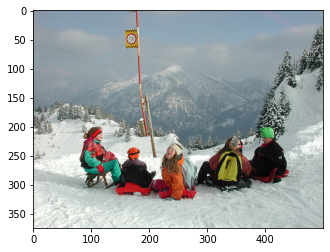

In [95]:
show_caption('99171998_7cc800ceef.jpg')

Actual Caption
startseq person stands near golden walls endseq
startseq woman behind scrolled wall is writing endseq
startseq woman standing near decorated wall writes endseq
startseq the walls are covered in gold and patterns endseq
startseq "woman writing on pad in room with gold decorated walls ." endseq

Model Predicted Caption
startseq man and woman sitting on wooden wall endseq


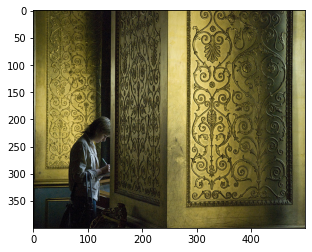

In [94]:
show_caption('997338199_7343367d7f.jpg')

Actual Caption
startseq boy jumps into the pool endseq
startseq an adult watches child somersault into the pool while another child looks on endseq
startseq woman throwing little boy into the pool endseq
startseq woman in blue is tossing young child into pool endseq
startseq woman throws little boy into pool as another boy watches endseq

Model Predicted Caption
startseq two children jump into pool endseq


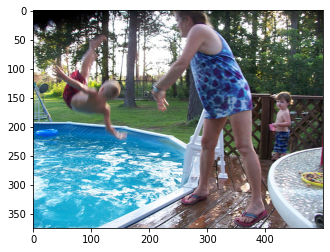

In [76]:
show_caption('950411653_20d0335946.jpg')

Actual Caption
startseq mountain landscape endseq
startseq mountainous photo is complete with blue sky endseq
startseq snowy mountain range endseq
startseq rocky mountains endseq
startseq snow covered peaks endseq

Model Predicted Caption
startseq person is climbing rocky cliff endseq


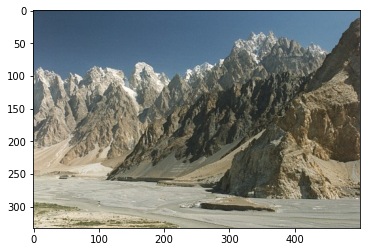

In [92]:
show_caption('95151149_5ca6747df6.jpg')

Actual Caption
startseq guy is riding bike up the side of hill endseq
startseq young man bicycles towards the camera and away from beautiful mountains on clear day endseq
startseq man on bike in mountains endseq
startseq man riding bicycle down narrow path endseq
startseq man riding bike on trail endseq

Model Predicted Caption
startseq man is hiking up hill endseq


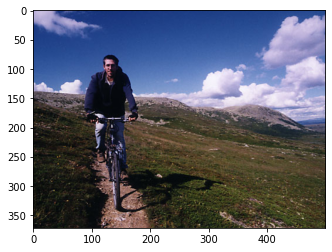

In [87]:
show_caption('95728660_d47de66544.jpg')

Actual Caption
startseq runner in yellow shirt is cresting hill endseq
startseq runner with one green shoe and one white shoe runs uphill endseq
startseq single runner is watched by onlookers in race endseq
startseq man wearing green sneakers runs down highway endseq
startseq the runner in red and yellow has just made it up the hill endseq

Model Predicted Caption
startseq man in red shirt is riding bike on the beach endseq


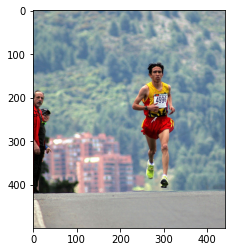

In [85]:
show_caption('956164675_9ee084364e.jpg')

Actual Caption
startseq beagle dog is walking on the shoreline at the beach endseq
startseq beagle walking on the beach next to some waves endseq
startseq beagle walks along the calm shore endseq
startseq the beagle is on beach walking along the shoreline endseq
startseq the beagle is walking on the beach at the waterline endseq

Model Predicted Caption
startseq dog runs on the beach endseq


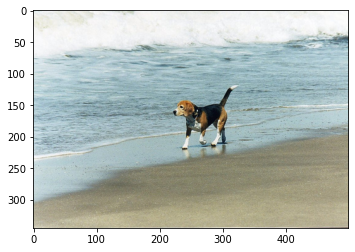

In [84]:
show_caption('953941506_5082c9160c.jpg')

Actual Caption
startseq couple of men sit by large stone slab with mountains in the background endseq
startseq two men rest near mountain range endseq
startseq two men sit against stone monument among snow covered peaks endseq
startseq two men sit at encripted stone in the mountains endseq
startseq two men sitting next to tall stone endseq

Model Predicted Caption
startseq man is sitting on folding folding chairs on the ground endseq


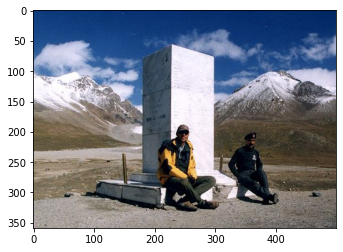

In [81]:
show_caption('95728664_06c43b90f1.jpg')

Actual Caption
startseq female in pink tank top drinking beer endseq
startseq "a woman in dark pink tank top has bag across her shoulder ." endseq
startseq woman in pink tank top drinking out of plastic glass endseq
startseq woman in pink tank top holds plastic beer mug endseq
startseq woman wearing pink tank top holding mug of liquid endseq

Model Predicted Caption
startseq girl in pink shirt and sunglasses is wearing black shirt and sunglasses endseq


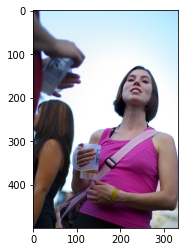

In [77]:
show_caption('954987350_a0c608b467.jpg')

Despite some figures not being adequately described by the model generated caption, it does a decent job decribing some pictures. The model performance can be improved by training the model for even more epochs.